In [1]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets


!pip install torchinfo
import torchinfo

import matplotlib.pyplot as plt
import numpy as np

import requests
import zipfile
from pathlib import Path
import os

from PIL import Image

import random

from typing import List, Tuple, Dict
from tqdm.auto import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
from going_modular import data_setup, engine

In [4]:
home_path = Path.cwd()
data_path = home_path / 'data'

if not data_path.exists():
    data_path.mkdir(exist_ok=True, parents=True)
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        response = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi.zip?raw=true")
        f.write(response.content)

    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        zip_ref.extractall(data_path)

train_dir = data_path / "train"
test_dir = data_path / "test"

train_dir, test_dir

(PosixPath('/content/data/train'), PosixPath('/content/data/test'))

## Data tranforms for transfer learning

It is vital to transform the images from the custom dataset to have the same tranforms as the images on which the model you are tranferring from previously used.

We can either do this automatically

Or we can create the transforms manually -> Normalize and resize the image for this

In [5]:
from going_modular import data_setup

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])


In [6]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir, test_dir, transform=manual_transform, batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7ad92e37d300>,
 ['pizza', 'steak', 'sushi'])

#### Automatic data transform creation using pretrained model weights

In [7]:
# get a set of pretrained model weights

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [8]:
# Get the tranforms

auto_tranforms = weights.transforms()
auto_tranforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [9]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir, test_dir, transform=auto_tranforms, batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7ad92df43df0>,
 ['pizza', 'steak', 'sushi'])

### Getting a pretrained model

1. Pytorch libraries
2. Libraries like timm(torch image models)
3. HuggingFace hub
4. PapersWithCode

In [10]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [11]:
torchinfo.summary(model, input_size=(1, 3, 224, 224),
                  col_names=["input_size", "output_size", "num_params", "trainable"],
                  row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]          [1, 1000]                 --                        True
├─Sequential (features)                                      [1, 3, 224, 224]          [1, 1280, 7, 7]           --                        True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]          [1, 32, 112, 112]         --                        True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]          [1, 32, 112, 112]         864                       True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]         [1, 32, 112, 112]         64                        True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]         [1, 32, 112, 112]         --                

## Feature-Extraction

We want to:
1. Freeze the earlier layers
2. Change the output to a size of 3 from 1000

In [12]:
for param in model.features.parameters():
    param.requires_grad = False

In [13]:
model.classifier = nn.Sequential(
    nn.Dropout(0.2, inplace=True),
    nn.Linear(1280, len(class_names))
)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [14]:
torchinfo.summary(model, input_size=(1, 3, 224, 224),
                  col_names=["input_size", "output_size", "num_params", "trainable"],
                  row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]          [1, 3]                    --                        Partial
├─Sequential (features)                                      [1, 3, 224, 224]          [1, 1280, 7, 7]           --                        False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]          [1, 32, 112, 112]         --                        False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]          [1, 32, 112, 112]         (864)                     False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]         [1, 32, 112, 112]         (64)                      False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]         [1, 32, 112, 112]         --         

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [16]:
from going_modular import engine
from timeit import default_timer as timer

start = timer()
results = engine.train(model = model,
                       train_dataloader = train_dataloader,
                       test_dataloader = test_dataloader,
                       loss_fn = loss_fn,
                       optimizer = optimizer,
                       device = device,
                       epochs=100)
end = timer()
print(f"Time taken: {end - start}")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0908 | train_acc: 0.3984 | test_loss: 0.8302 | test_acc: 0.8551
Epoch: 2 | train_loss: 0.8552 | train_acc: 0.8086 | test_loss: 0.7715 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7731 | train_acc: 0.7461 | test_loss: 0.7059 | test_acc: 0.8362
Epoch: 4 | train_loss: 0.6794 | train_acc: 0.7695 | test_loss: 0.5760 | test_acc: 0.8551
Epoch: 5 | train_loss: 0.5996 | train_acc: 0.7695 | test_loss: 0.5635 | test_acc: 0.8561
Epoch: 6 | train_loss: 0.5541 | train_acc: 0.7852 | test_loss: 0.5032 | test_acc: 0.8352
Epoch: 7 | train_loss: 0.5323 | train_acc: 0.7852 | test_loss: 0.5170 | test_acc: 0.8561
Epoch: 8 | train_loss: 0.4607 | train_acc: 0.9453 | test_loss: 0.4604 | test_acc: 0.8456
Epoch: 9 | train_loss: 0.4631 | train_acc: 0.8086 | test_loss: 0.4858 | test_acc: 0.8769
Epoch: 10 | train_loss: 0.4989 | train_acc: 0.8242 | test_loss: 0.4424 | test_acc: 0.8759
Epoch: 11 | train_loss: 0.3993 | train_acc: 0.9531 | test_loss: 0.4402 | test_acc: 0.8456
Epoch: 12 | train_l

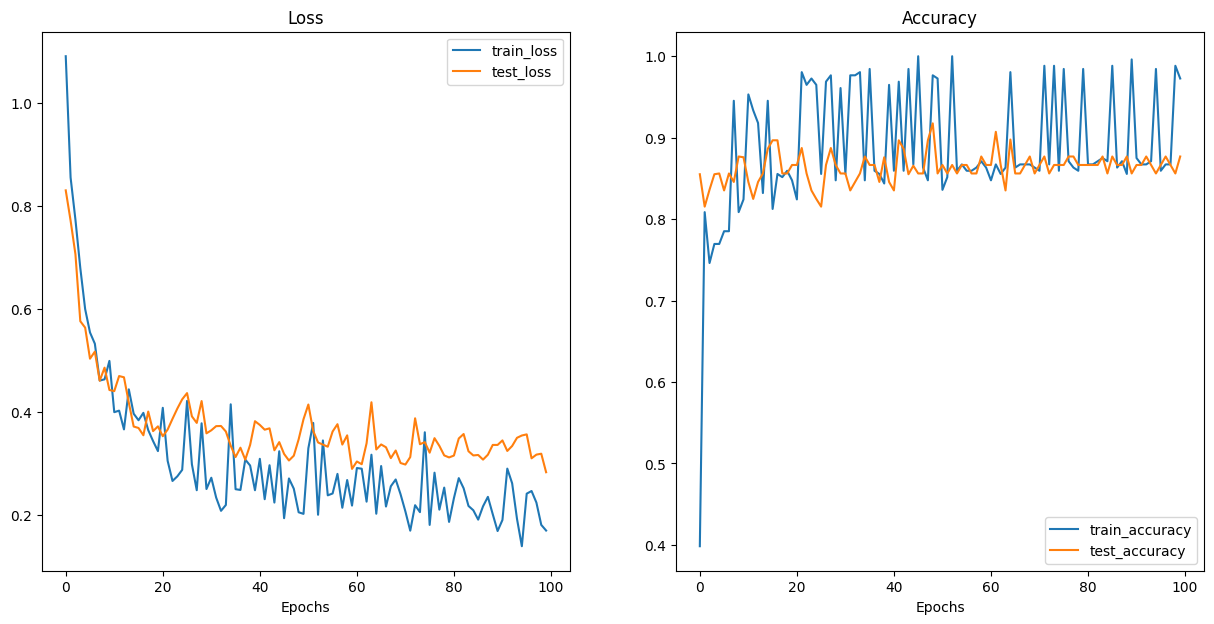

In [17]:
from going_modular import helper_functions

helper_functions.plot_loss_curves(results)